In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Get the merged data of the train and store

In [59]:
def get_data():
    logging.info('fetch the csv data')
    df = pd.read_csv('../../data/merged.csv')
    df = df.head(100000)
    print(len(df))
    logging.info('check for missing values')
    print(df.isnull().sum())
    
    return df

In [60]:
def clean_data(df):
    logging.info('fill missing values')
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna(0, inplace=True)

    df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
    df['CompetitionOpenSinceYear'].fillna(0, inplace=True)

    logging.info('check for missing values')
    print(df.isnull().sum())

    logging.info('Get additional paramaeters from the Date column')
    df['DayOfMonth'] = pd.to_datetime(df['Date']).dt.day
    df['IsMonthStart'] = pd.to_datetime(df['Date']).dt.is_month_start
    df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end 
    print(df.info())

    logging.info('Save the new features into the merged data')
    df.to_csv('../../data/merged.csv', index=False)

    return df

In [61]:
def data_preprocessing(df):
    logging.info('one hot encoding for the categoriacal variables like store type and assortment')
    if 'StoreType' in df.columns:
        df = pd.get_dummies(df, columns=['StoreType', 'Assortment'], drop_first=True, dtype=int)
    if  'Assortment' in df.columns:
        df = pd.get_dummies(df, columns=['Assortment'], drop_first=True, dtype=int)
    if 'StateHoliday' in df.columns:
        df = pd.get_dummies(df, columns=['StateHoliday'], drop_first=True, dtype=int)
    print(df.head(5))

    logging.info('Handling PromoInterval')
    df['PromoInterval'] = df['PromoInterval'].fillna('0')
    df['PromoMonths'] = df['PromoInterval'].apply(lambda x: len(str(x).split(',')) if x != '0' else 0)
    df = df.drop('PromoInterval', axis=1)

    return df


In [62]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder
def prepare_model(df):
    logging.info("define the numerical columns")
    numeric_cols = ['DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 
                    'CompetitionDistance', 'Promo2SinceYear', 'Promo2SinceWeek', 
                    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
                    'Year', 'Month', 'DayOfMonth', 'WeekOfYear',
                    'IsMonthStart', 'IsMonthEnd']
    
    logging.info('define the catagorical columns')
    logging.info('Defining the categorical columns')
    categorical_cols = [col for col in df.columns if col.startswith(('StoreType_', 'Assortment_', 'StateHoliday_'))]


    logging.info('define the transformer for the numerical columns')

    numeric_transformer = Pipeline(steps=[('scalar', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])


    logging.info('update the preprocessor pipline')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    logging.info('regression pipline with the preprocessor and random forest regressor')
    regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    return regression_pipeline

In [63]:
def train_model(df, model):
    logging.info('split the data into train and test')
    X = df.drop(['Sales', 'Date'], axis=1)
    y = df['Sales']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    logging.info('train the model')
    model.fit(X_train, y_train)

    logging.info('predict the model')
    y_pred = model.predict(X_test)
    print(y_pred)

    logging.info('evaluate the model')
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    return [model,y_test, y_pred,X_test]

In [64]:
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Sales')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Sales')
    plt.xlabel('Data Points')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


In [65]:
def get_feature_importance(regression_pipeline):
    # Accessing the RandomForestRegressor from the pipeline
    rf_model = regression_pipeline.named_steps['regressor']

    # If you're using a ColumnTransformer for preprocessing, access it first
    preprocessor = regression_pipeline.named_steps['preprocessor']  # Replace 'preprocessor' with the actual name

    # Get the transformed feature names
    feature_names = preprocessor.get_feature_names_out()

    # Extracting feature importances
    importance = rf_model.feature_importances_

    # Ensure the lengths match
    print(f'Number of transformed features: {len(feature_names)}')
    print(f'Number of feature importances: {len(importance)}')

    # Creating a DataFrame for better readability
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,  # Transformed feature names
        'importance': importance
    })

    # Sorting the features by their importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Display the top features
    print(feature_importance_df.head(10))  # Adjust the number of top features to display
    return feature_importance_df


In [66]:
def plot_feature_importance(feature_importance_df):
    logging.info('show the feature importance with a plot')
    top_n = 10  # You can adjust the number of features to display
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')

    # Adding labels and title
    plt.title(f'Top {top_n} Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

    # Show the plot
    plt.show()

In [67]:
from sklearn.utils import resample
def bootstrap_predictions(model, X_test, n_iterations=100):
    preds = []
    for i in range(n_iterations):
        X_sample = resample(X_test)
        preds_sample = model.predict(X_sample)
        preds.append(preds_sample)
    preds = np.array(preds)
    lower = np.percentile(preds, 2.5, axis=0)
    upper = np.percentile(preds, 97.5, axis=0)
    return lower, upper

def predict_with_bootstrap(regression_pipeline, X_test):
    lower_ci, upper_ci = bootstrap_predictions(regression_pipeline, X_test)
    return [lower_ci, upper_ci]

In [68]:
def plot_with_bootstrap(y_pred, lower_ci, upper_ci):    
    logging.info('plot the confidence interval')
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred, label='Predictions', color='blue')
    plt.fill_between(range(len(y_pred)), lower_ci, upper_ci, color='lightblue', alpha=0.5, label='Confidence Interval (95%)')
    plt.title('Predictions with 95% Confidence Intervals')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Sales')
    plt.legend()
    plt.show()

In [69]:
import joblib
def export_model(model, regression_pipeline):
    logging.info('serialize the model')
    # Serialize the model
    filename = 'model.pkl'
    joblib.dump(regression_pipeline, filename)
    print(f'Model saved as {filename}')

/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_11794/2172435094.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/merged.csv')
/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_11794/3378609153.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Promo2SinceWeek'].fillna(0, inplace=True)
/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_11794/3378609153.py:4: FutureWarning: A value is trying to be set on a co

100000
Id                           0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
DayOfMonth                   0
IsMonthStart                 0
IsMonthEnd                   0
dtype: int64
Id                           0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2             

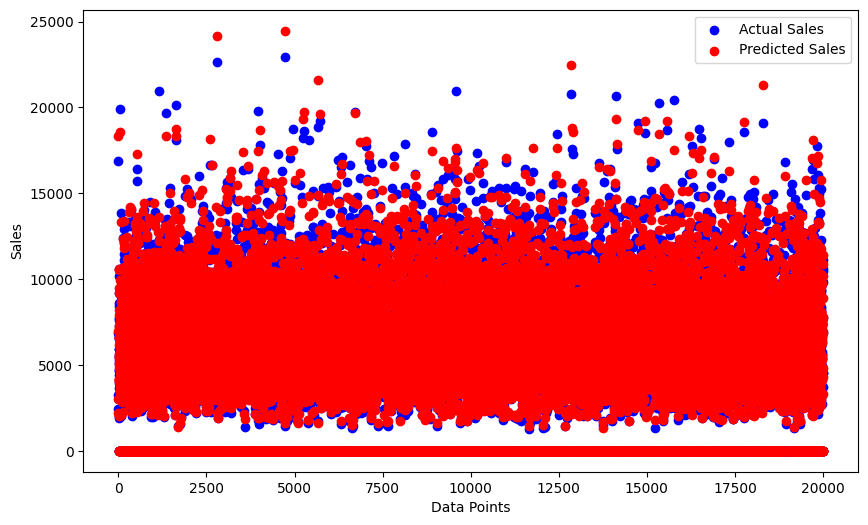

Number of transformed features: 23
Number of feature importances: 23
                           feature  importance
1                   num__Customers    0.869893
18              cat__StoreType_d_1    0.027897
3                       num__Promo    0.023439
5         num__CompetitionDistance    0.022856
9    num__CompetitionOpenSinceYear    0.013489
7             num__Promo2SinceWeek    0.009681
8   num__CompetitionOpenSinceMonth    0.008174
6             num__Promo2SinceYear    0.006785
0                   num__DayOfWeek    0.004306
12                 num__DayOfMonth    0.002928


/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_11794/3255354407.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')


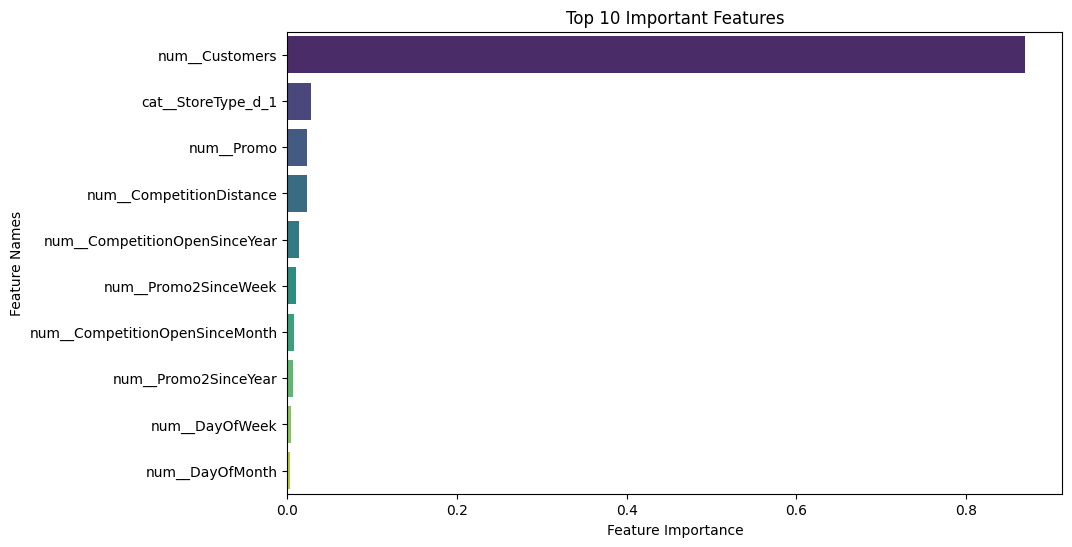

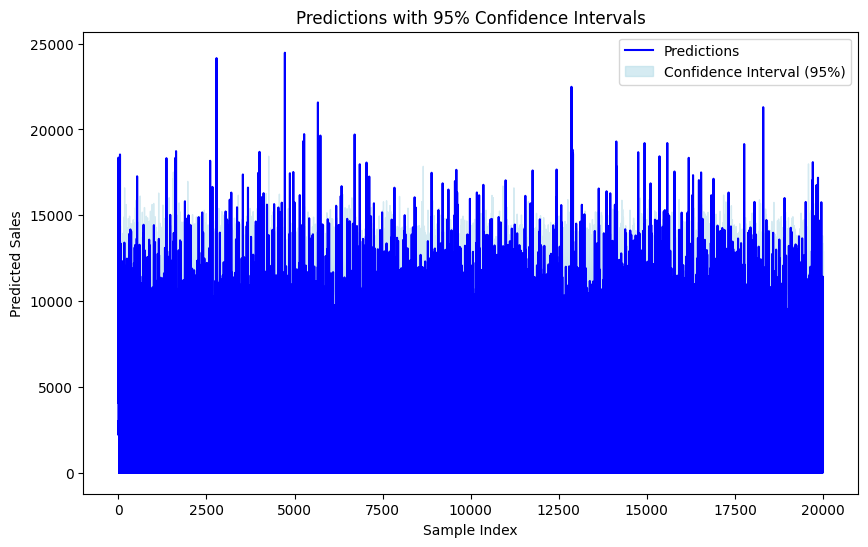

Model saved as model.pkl


In [70]:
# run every thing here
df = get_data()
df = clean_data(df)
df = data_preprocessing(df)
regression_pipline = prepare_model(df)
model = train_model(df, regression_pipline)
model, y_test, y_pred,X_test = model
plot_results(y_test, y_pred)
feat_data = get_feature_importance(model)
plot_feature_importance(feat_data)
lower_ci, upper_ci = predict_with_bootstrap(model, X_test)
plot_with_bootstrap(y_pred, lower_ci, upper_ci)
export_model(model, regression_pipline)
